## Vincent T. Cooper ##
#### Start: 13 May 2021 ##
In this notebook, I preprocess results from the updated version of the coupled wave-ice model.
The goal is to get the data into the same format as the past version, so that I can:  
1 Run the distance-from-ice-edge calculation on new model results, and  
2 Repeat the past analysis outputs, which require the distance grouping.

In [1]:
import numpy as np
import os
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
# from matplotlib.colors import DivergingNorm
# import matplotlib.patches as patches
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns; sns.set(color_codes=False)
import cmocean
# from windrose import WindroseAxes
import warnings

import cftime
import datetime


plt.rcParams['xtick.bottom'] = True # keep my tick marks
plt.rcParams['ytick.left'] = True
plt.rcParams['font.size'] = 18
plt.rcParams["font.family"] = "Arial"
# plt.rcParams['figure.figsize'] = 12,8
# mpl.rcParams['figure.dpi'] = 300 # activate for presentation quality

from sklearn.metrics.pairwise import haversine_distances

## this is a dummy grid that has the right conventions
grid = xr.open_dataset(
    '/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')

## circle boundary for plotting
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpl.path.Path(verts * radius + center)

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


In [2]:
##### MODEL DATA #####
mdir = '/glade/work/lettier/CICE/cicefsdww3i_output_concat/' ## location of file before changing dim names
mdir_adj = '/glade/u/home/vcooper/work/BGEP_vtc/adjfiles/' # location of adjusted files, changed dims to lat and lon
timeslice1719 = slice('2017-01-01','2019-12-31')
latslice = slice(300,384)

## output from distance calculation, using wavewatch data originally
dist_model = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/model_iceedgedistance_2000-2019.nc') 

## keep cice 2018 output because of detailed grid
cice18 = xr.open_dataset(mdir_adj + 'cicefsdww3i.cice.h1.0086.nc') # 2018 rerun
cice18.TLAT[:] = grid.lat # hack to fix polar stereo
cice18.TLON[:] = grid.lon
tarea = cice18.tarea.rename(
    {'TLON':'longitude','TLAT':'latitude'}).reset_coords(names=['ULON','ULAT'],drop=True)

## wavewatch output
ww1719ef = xr.open_dataset(mdir_adj + 'ww3.2017-2019_ef.nc').set_coords(['longitude','latitude'])

## wavewatch results excl. spectra
ww0019 = xr.open_dataset(
    '/glade/work/vcooper/BGEP_vtc/cicefsdww3i.ww3.sigheight.2000-2019.nc').set_coords(
    ['longitude','latitude']) # 6 hourly
xr.merge([ww0019,tarea],compat='override') # disagreements on latitude fill values, seems to be no factor

## revised mask for beaufort (post AGU poster)
latmin = 72
latmax = 79
lonmin = 195
lonmax = 230
beau_mask = (
    (dist_model.coords['longitude'] > lonmin) 
    & (dist_model.coords['longitude'] < lonmax)
    & (dist_model.coords['latitude'] > latmin)
    & (dist_model.coords['latitude'] < latmax)
)

## wavewatch spectra, only have '17-'19
ww1719beau = ww0019.sel(time=timeslice1719,nj=latslice)
ww1719beau.coords['mask'] = (('nj','ni'), beau_mask)
dist_model.coords['mask'] = (('nj','ni'), beau_mask)

dist1719beau = dist_model.sel(time=timeslice1719)
dist1719beau = dist1719beau.where(dist1719beau.mask > 0, drop=True)

ww1719beau_cat = xr.open_dataset('./ww1719beau_cat.nc')
ww1719beau_cat = ww1719beau_cat.where((
    ww1719beau_cat.longitude > lonmin) 
    & (ww1719beau_cat.longitude < lonmax)
    & (ww1719beau_cat.latitude > latmin)
    & (ww1719beau_cat.latitude < latmax),
    drop=True)

ww1719ef_beau_cat = xr.open_dataset('./ww1719ef_beau_cat.nc')
ww1719ef_beau_cat = ww1719ef_beau_cat.where((
    ww1719ef_beau_cat.longitude > lonmin) 
    & (ww1719ef_beau_cat.longitude < lonmax)
    & (ww1719ef_beau_cat.latitude > latmin)
    & (ww1719ef_beau_cat.latitude < latmax),
    drop=True)

ww1719beau_cat['dist'] = dist1719beau

######################

##### SATELLITE OBS from NSIDC, regridded to match CICE grid #####
path = '/glade/work/vcooper/BGEP_vtc/regrid_sat/' ## location of regridded file
ice_file = 'seaice_conc_daily_nh_1979-2019_cicegrid.nc' # name of regridded file
ice_file_originalgrid = 'seaice_conc_daily_nh_1979-2019.nc' # name of original file
boot = (xr.open_dataset(path+ice_file)).rename_vars(seaice_conc_cdr='aice_d')
# boot_native = (xr.open_dataset(path+ice_file_originalgrid)).rename_vars(seaice_conc_cdr='aice_d')

## pre-calculated distance from ice edge for satellite data
dist_sat = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_2012-2019.nc').rename('cdr').to_dataset()
dist_sat_bt = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_bt_2012-2019.nc').rename('bt').to_dataset()
dist_sat_nt = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_nt_2012-2019.nc').rename('nt').to_dataset()
dist_sat_all = xr.merge([dist_sat,dist_sat_bt,dist_sat_nt],)

## fix grid
dist_sat_all.TLON[:] = ww0019.sel(nj=latslice).longitude.values
dist_sat_all.TLAT[:] = ww0019.sel(nj=latslice).latitude.values

#############################################################


##### IN SITU OBSERVATIONS #####
## read in new mooring data revised by Jim Thomson Sep 2020
BGOS_dir = '/glade/work/vcooper/BGEP_vtc/BGOS-AWAC_resultsv02/'
bgosA = xr.open_dataset(BGOS_dir + 'BGOS-A_AWAC.mat_converted.nc')
bgosD = xr.open_dataset(BGOS_dir + 'BGOS-D_AWAC.mat_converted.nc')

## read in latest SODA data on waves
sodaA = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_A_sigWaves.mat_converted_2020-07-27.nc')
sodaB = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_B_sigWaves.mat_converted_2020-07-27.nc')
sodaC = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_C_sigWaves.mat_converted_2020-07-27.nc')

## SWIFT buoys
swiftpath = '/glade/work/lettier/SWIFT_SeaState2015/'
swift_files = ('SWIFT13_11-14Oct2015_30min_converted.nc','SWIFT11_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT09_06-08Oct2015_30min_converted.nc','SWIFT15_23-25Oct2015_30min_converted.nc',
              'SWIFT12_02Oct2015_30min_converted.nc','SWIFT11_23-24Oct2015_30min_converted.nc',
              'SWIFT09_11-14Oct2015_30min_converted.nc','SWIFT11_10Oct2015_30min_converted.nc',
              'SWIFT14_23-24Oct2015_30min_converted.nc','SWIFT09_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT12_23-24Oct2015_30min_converted.nc','SWIFT15_11-13Oct2015_30min_converted.nc',
              'SWIFT14_10Oct2015_30min_converted.nc','SWIFT09_02Nov2015_30min_converted.nc',
              'SWIFT14_04Oct2015_30min_converted.nc','SWIFT13_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT14_11-13Oct2015_30min_converted.nc','SWIFT13_23-24Oct2015_30min_converted.nc',
              'SWIFT14_16-18Oct2015_30min_converted.nc','SWIFT15_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT11_16-18Oct2015_30min_converted.nc','SWIFT11_11-14Oct2015_30min_converted.nc',
              'SWIFT09_23-24Oct2015_30min_converted.nc','SWIFT11_04Oct2015_30min_converted.nc',
              'SWIFT12_11-14Oct2015_30min_converted.nc','SWIFT12_04Oct2015_30min_converted.nc',
              'SWIFT12_06-08Oct2015_30min_converted.nc')

swift_files = sorted(swift_files)  # sorted list of all SWIFT files
swift_names = swift_files # initialize list of shortened names for use as xarray data
swift_dict = {}
nswift = len(swift_names)

for i, file in enumerate(swift_files):
    swift_names[i] = file[:-19] # drops final 19 chars
    swift_dict[swift_names[i]] = xr.open_dataset(swiftpath + file) # datasets for each file, key to swift_names

swift_dist = {} # new dictionary to hold distances for swifts
swift_dist_bt = {} 
swift_dist_nt = {} 

## shortcut dictionary to index grid cells of in situ obs
nj = {}
nj['bds12'] = 349
nj['bds15'] = 350
nj['bds17'] = 349
nj['bds18'] = 349
nj['bgosA'] = 349
nj['bgosD'] = 350
nj['sodaA'] = 347
nj['sodaB'] = 351
nj['sodaC'] = 356

ni = {}
ni['bds12'] = 206
ni['bds15'] = 214
ni['bds17'] = 206
ni['bds18'] = 206
ni['bgosA'] = 206
ni['bgosD'] = 214
ni['sodaA'] = 209
ni['sodaB'] = 208
ni['sodaC'] = 207

for key,da in swift_dict.items():
    
    ## code to find model grid cell closest to lat lon of obs
    templat = np.tile(da.lat.values.mean(),
                  cice18.TLAT.values.size).reshape(cice18.TLAT.values.shape)
    templon = np.tile(da.lon.values.mean(),
                      cice18.TLON.values.size).reshape(cice18.TLON.values.shape) + 360
    difflat = templat - cice18.TLAT.values
    difflon = templon - cice18.TLON.values
    dist = difflat**2 + difflon**2
    njtemp = np.where(dist == np.min(dist))[0][0]
    nitemp = np.where(dist == np.min(dist))[1][0]
    nj[key] = njtemp
    ni[key] = nitemp

################################

## Scratch mess of preprocessing
## this was actually the later step after i made files for each year
## here i adjust and concatenate them all into one file
## so this is the final preprocessing step

In [3]:
%%time
###### Coupled Model Update May 2021 #####
## loading in and concat data 
ww2012 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2012.nc')
ww2013 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2013.nc')
ww2014 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2014.nc')
ww2015 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2015.nc')
ww2016 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2016.nc')
ww2017 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2017.nc')
ww2018 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2018.nc')
ww2019 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2019.nc')

ww_dict = {'ww2012' : ww2012,
           'ww2013' : ww2013,
           'ww2014' : ww2014,
           'ww2015' : ww2015,
           'ww2016' : ww2016,
           'ww2017' : ww2017,
           'ww2018' : ww2018,
           'ww2019' : ww2019}

## get frequency domain from old data
temp_f = xr.open_dataset('./ww1719ef_beau_cat.nc')

for key,val in ww_dict.items():
    print(key)
    val = val.rename({'UAX': 'uwnd',
                'UAY': 'vwnd',
                'ICE': 'ice',
                'HS':  'hs',
                'T02': 't02',
                'T0M1':'t0m1',
                'T01': 't01',
                'FP0': 'fp',
                'THM': 'dir',
                'EF':  'ef',
                'FREQ':'f',
                'NX':  'ni',
                'NY':  'nj'})

    val['latitude'] = (['nj','ni'],grid.lat.values)
    val['longitude'] = (['nj','ni'],grid.lon.values)
    val = val.set_coords(['time','latitude','longitude'])
    val['f'] = temp_f.f
    val = val.sel(nj=latslice)
    val.coords['mask'] = (('nj','ni'), beau_mask)
    val = val.where(val.mask > 0, drop=True)
    ww_dict[key] = val

##########################################

ww2012


KeyboardInterrupt: 

In [48]:
%%time
ww_allbeau = xr.concat([ww_dict['ww2012'],
                        ww_dict['ww2013'],
                        ww_dict['ww2014'],
                        ww_dict['ww2015'],
                        ww_dict['ww2016'],
                        ww_dict['ww2017'],
                        ww_dict['ww2018'],
                        ww_dict['ww2019']],dim='time')

CPU times: user 1.66 s, sys: 4.77 s, total: 6.43 s
Wall time: 7.42 s


In [54]:
%%time
## save netcdf
new_filename = '/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2012-2019.beau.nc'
print ('saving to ', new_filename)

ww_allbeau.to_netcdf(path=new_filename)
print ('finished saving')

saving to  /glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2012-2019.beau.nc
finished saving
CPU times: user 30.6 ms, sys: 1.25 s, total: 1.28 s
Wall time: 2.81 s


### Here we load in the new run from CMB directory and make into annual datasets
Still including the hourly output though.
Make some adjustments so that we can do the distance calculations.


In [17]:
hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
path_pre_year = hourly_path + 'cesm23iws1tsks.ww3.hi.'

/glade/scratch/bitz/cesm23iws1tsks/run/hourly/cesm23iws1tsks.ww3.hi.2012-01-01*.nc


In [18]:
ww2012 = xr.open_mfdataset(path_pre_year + '2012-01-01*.nc',combine='nested',concat_dim='time')
ww2012

<xarray.Dataset>
Dimensions:  (FREQ: 25, NX: 320, NY: 384, time: 24)
Dimensions without coordinates: FREQ, NX, NY, time
Data variables:
    UAX      (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    UAY      (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    ICE      (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    HS       (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    T02      (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    T0M1     (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    T01      (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    FP0      (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    THM      (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    EF       (time, FREQ, NY, NX) float32 dask.array<chunksize=(1, 25, 384, 320), meta=np.ndarray>

In [38]:
## add latitude and longitude coords
ww2012 = xr.open_mfdataset(path_pre_year + '2012-01-01*.nc',
                           combine='nested',concat_dim='time')
ww2012['latitude'] = (['NY','NX'],grid.lat.values)
ww2012['longitude'] = (['NY','NX'],grid.lon.values)
ww2012 = ww2012.set_coords(['latitude','longitude'])

<xarray.Dataset>
Dimensions:    (FREQ: 25, NX: 320, NY: 384, time: 24)
Coordinates:
    latitude   (NY, NX) float64 -79.22 -79.22 -79.22 ... 9.969e+36 9.969e+36
    longitude  (NY, NX) float64 320.6 321.7 322.8 ... 9.969e+36 9.969e+36
Dimensions without coordinates: FREQ, NX, NY, time
Data variables:
    UAX        (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    UAY        (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    ICE        (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    HS         (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    T02        (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    T0M1       (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    T01        (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    FP0        (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    THM        (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    EF         (time, FREQ, NY, NX) float32 dask.array<chunksize=(1, 25, 384, 320), meta=np.ndarray>

In [37]:
ww2012.time

<xarray.DataArray 'time' (time: 24)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23])
Dimensions without coordinates: time

In [27]:
## set up file loading
hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
path_pre_year = hourly_path + 'cesm23iws1tsks.ww3.hi.'

## load data, add latitude and longitude coords
year_sel = '2012'
ww_temp = xr.open_mfdataset(path_pre_year + year_sel + '-01-01*.nc',
                           combine='nested',concat_dim='time')
ww_temp['latitude'] = (['NY','NX'],grid.lat.values)
ww_temp['longitude'] = (['NY','NX'],grid.lon.values)
ww_temp = ww_temp.set_coords(['latitude','longitude'])

## initialize distances
ice_conc_data = ww_temp.ICE
distances = np.zeros(ice_conc_data.shape)

## loop through time
for i in range(len(distances)):
    distances[i] = icedistance(ice_conc_data[i])

## convert to xarray
distances_da = xr.DataArray(distances, dims=ice_conc_data.dims,coords=ice_conc_data.coords)

## save netcdf
new_filename = '/glade/scratch/vcooper/waveice_analysis/distance_calc/cesm23iws1tsks.ww3.hi.icedistance.' + year + '.nc'
print ('saving to ', new_filename)

distances_da.to_netcdf(path=new_filename)
print ('finished saving')

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 620 ms, sys: 13.8 ms, total: 634 ms
Wall time: 678 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 622 ms, sys: 10.9 ms, total: 633 ms
Wall time: 673 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 630 ms, sys: 8.82 ms, total: 639 ms
Wall time: 675 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 628 ms, sys: 9.87 ms, total: 638 ms
Wall time: 677 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 630 ms, sys: 8.94 ms, total: 639 ms
Wall time: 679 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 633 ms, sys: 11.9 ms, total: 645 ms
Wall time: 696 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 632 ms, sys: 6.78 ms, total: 638 ms
Wall time: 678 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 628 ms, sys: 7.86 ms, total: 636 ms
Wall time: 674 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 633 ms, sys: 7.91 ms, total: 641 ms
Wall time: 691 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 629 ms, sys: 13.9 ms, total: 643 ms
Wall time: 685 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 632 ms, sys: 8.93 ms, total: 641 ms
Wall time: 673 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 634 ms, sys: 7.93 ms, total: 642 ms
Wall time: 678 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 640 ms, sys: 3.87 ms, total: 644 ms
Wall time: 684 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 635 ms, sys: 5.89 ms, total: 641 ms
Wall time: 679 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 629 ms, sys: 11.9 ms, total: 640 ms
Wall time: 683 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 625 ms, sys: 9.95 ms, total: 635 ms
Wall time: 686 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 631 ms, sys: 8.92 ms, total: 639 ms
Wall time: 683 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 631 ms, sys: 8.92 ms, total: 640 ms
Wall time: 672 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 634 ms, sys: 7.92 ms, total: 642 ms
Wall time: 677 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 632 ms, sys: 6.94 ms, total: 639 ms
Wall time: 694 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 632 ms, sys: 8.96 ms, total: 641 ms
Wall time: 674 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 634 ms, sys: 6.98 ms, total: 641 ms
Wall time: 683 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 626 ms, sys: 12.9 ms, total: 639 ms
Wall time: 666 ms
CPU times: user 632 ms, sys: 4.99 ms, total: 637 ms
Wall time: 675 ms


In [ ]:
yrs = np.array([2019])
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for yr in yrs:
        print(str(yr))
        distance_calc_output(str(yr))

2019
1 / 8760
2 / 8760
3 / 8760
4 / 8760
5 / 8760
6 / 8760
7 / 8760
8 / 8760
9 / 8760
10 / 8760
11 / 8760
12 / 8760
13 / 8760
14 / 8760
15 / 8760
16 / 8760
17 / 8760
18 / 8760
19 / 8760
20 / 8760
21 / 8760
22 / 8760
23 / 8760
24 / 8760
25 / 8760
26 / 8760
27 / 8760
28 / 8760
29 / 8760
30 / 8760
31 / 8760
32 / 8760
33 / 8760
34 / 8760
35 / 8760
36 / 8760
37 / 8760
38 / 8760
39 / 8760
40 / 8760
41 / 8760
42 / 8760
43 / 8760
44 / 8760
45 / 8760
46 / 8760
47 / 8760
48 / 8760
49 / 8760
50 / 8760
51 / 8760
52 / 8760
53 / 8760
54 / 8760
55 / 8760
56 / 8760
57 / 8760
58 / 8760
59 / 8760
60 / 8760
61 / 8760
62 / 8760
63 / 8760
64 / 8760
65 / 8760
66 / 8760
67 / 8760
68 / 8760
69 / 8760
70 / 8760
71 / 8760
72 / 8760
73 / 8760
74 / 8760
75 / 8760
76 / 8760
77 / 8760
78 / 8760
79 / 8760
80 / 8760
81 / 8760
82 / 8760
83 / 8760
84 / 8760
85 / 8760
86 / 8760
87 / 8760
88 / 8760
89 / 8760
90 / 8760
91 / 8760
92 / 8760
93 / 8760
94 / 8760
95 / 8760
96 / 8760
97 / 8760
98 / 8760
99 / 8760
100 / 8760
101

In [6]:
%%time
# yrs = np.arange(2014,2015+1)
yrs = np.array([2019])
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for yr in yrs:
        print(str(yr))
        distance_calc_output(str(yr))

2019
1 / 8760
2 / 8760
3 / 8760
4 / 8760
5 / 8760
6 / 8760
7 / 8760
8 / 8760
9 / 8760
10 / 8760
11 / 8760
12 / 8760
13 / 8760
14 / 8760
15 / 8760
16 / 8760
17 / 8760
18 / 8760
19 / 8760
20 / 8760
21 / 8760
22 / 8760
23 / 8760
24 / 8760
25 / 8760
26 / 8760
27 / 8760
28 / 8760
29 / 8760
30 / 8760
31 / 8760
32 / 8760
33 / 8760
34 / 8760
35 / 8760
36 / 8760
37 / 8760
38 / 8760
39 / 8760
40 / 8760
41 / 8760
42 / 8760
43 / 8760
44 / 8760
45 / 8760
46 / 8760
47 / 8760
48 / 8760
49 / 8760
50 / 8760
51 / 8760
52 / 8760
53 / 8760
54 / 8760
55 / 8760
56 / 8760
57 / 8760
58 / 8760
59 / 8760
60 / 8760
61 / 8760
62 / 8760
63 / 8760
64 / 8760
65 / 8760
66 / 8760
67 / 8760
68 / 8760
69 / 8760
70 / 8760
71 / 8760
72 / 8760
73 / 8760
74 / 8760
75 / 8760
76 / 8760
77 / 8760
78 / 8760
79 / 8760
80 / 8760
81 / 8760
82 / 8760
83 / 8760
84 / 8760
85 / 8760
86 / 8760
87 / 8760
88 / 8760
89 / 8760
90 / 8760
91 / 8760
92 / 8760
93 / 8760
94 / 8760
95 / 8760
96 / 8760
97 / 8760
98 / 8760
99 / 8760
100 / 8760
101

In [ ]:
%%time
yrs = np.arange(2016,2019+1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for yr in yrs:
        print(str(yr))
        distance_calc_output(str(yr))

2016
1 / 8760
2 / 8760
3 / 8760
4 / 8760
5 / 8760
6 / 8760
7 / 8760
8 / 8760
9 / 8760
10 / 8760
11 / 8760
12 / 8760
13 / 8760
14 / 8760
15 / 8760
16 / 8760
17 / 8760
18 / 8760
19 / 8760
20 / 8760
21 / 8760
22 / 8760
23 / 8760
24 / 8760
25 / 8760
26 / 8760
27 / 8760
28 / 8760
29 / 8760
30 / 8760
31 / 8760
32 / 8760
33 / 8760
34 / 8760
35 / 8760
36 / 8760
37 / 8760
38 / 8760
39 / 8760
40 / 8760
41 / 8760
42 / 8760
43 / 8760
44 / 8760
45 / 8760
46 / 8760
47 / 8760
48 / 8760
49 / 8760
50 / 8760
51 / 8760
52 / 8760
53 / 8760
54 / 8760
55 / 8760
56 / 8760
57 / 8760
58 / 8760
59 / 8760
60 / 8760
61 / 8760
62 / 8760
63 / 8760
64 / 8760
65 / 8760
66 / 8760
67 / 8760
68 / 8760
69 / 8760
70 / 8760
71 / 8760
72 / 8760
73 / 8760
74 / 8760
75 / 8760
76 / 8760
77 / 8760
78 / 8760
79 / 8760
80 / 8760
81 / 8760
82 / 8760
83 / 8760
84 / 8760
85 / 8760
86 / 8760
87 / 8760
88 / 8760
89 / 8760
90 / 8760
91 / 8760
92 / 8760
93 / 8760
94 / 8760
95 / 8760
96 / 8760
97 / 8760
98 / 8760
99 / 8760
100 / 8760
101

In [3]:
def distance_calc_output(year_sel):
    ## set up file loading
    hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
    path_pre_year = hourly_path + 'cesm23iws1tsks.ww3.hi.'

    ## load data, add latitude and longitude coords
    #year_sel = '2012'
    ww_temp = xr.open_mfdataset(path_pre_year + year_sel + '*.nc',
                               combine='nested',concat_dim='time')
    ww_temp['latitude'] = (['NY','NX'],grid.lat.values)
    ww_temp['longitude'] = (['NY','NX'],grid.lon.values)
    ww_temp = ww_temp.set_coords(['latitude','longitude'])

    ## initialize distances
    ice_conc_data = ww_temp.ICE
    distances = np.zeros(ice_conc_data.shape)

    ## loop through time
    for i in range(len(distances)):
        print(str(i+1) + ' / ' + str(len(distances)))
        distances[i] = icedistance(ice_conc_data[i])

    ## convert to xarray
    distances_da = xr.DataArray(distances, dims=ice_conc_data.dims,coords=ice_conc_data.coords)

    ## save netcdf
    new_filename = '/glade/scratch/vcooper/waveice_analysis/distance_calc/cesm23iws1tsks.ww3.hi.icedistance.' + year_sel + '.nc'
    print ('saving to ', new_filename)

    distances_da.to_netcdf(path=new_filename)
    print ('finished saving')

In [4]:
## Updated version to 15% ice concentration threshold
def icedistance(iceconc_input):
    # turn icefracs to numpy array
    icefracsnp = iceconc_input.values
#     lats = iceconc_input.TLAT.values
#     lons = iceconc_input.TLON.values
    lats = iceconc_input.latitude.values # wavewatch version
    lons = iceconc_input.longitude.values # wavewatch version


    # create array to hold the distances
    distances = icefracsnp.copy() # same size array as the evaluated data
    distances -= distances # make zeros or nan; we will keep these values for cells that don't need a calc

    
    ##### GET OPEN WATER -> WATER/ICE EDGE LOCATIONS #####
    
    # get all open water locations except at edge of domain to avoid computation breaking
    icefracsnp_noborder = icefracsnp[1:-1,1:-1] # exclude borders for open water checking neighbors
    locations_openw = np.transpose(np.where(icefracsnp_noborder<0.15))
    locations_openw += 1 # adjust indices for the border exclusion

    # create 4 arrays, each represents the offset of open water location in coords by 1 unit
    latp1 = np.append(locations_openw[:,0]+1,locations_openw[:,1]).reshape(locations_openw.shape,order='F')
    latm1 = np.append(locations_openw[:,0]-1,locations_openw[:,1]).reshape(locations_openw.shape,order='F')
    lonp1 = np.append(locations_openw[:,0],locations_openw[:,1]+1).reshape(locations_openw.shape,order='F')
    lonm1 = np.append(locations_openw[:,0],locations_openw[:,1]-1).reshape(locations_openw.shape,order='F')

    # get max icefrac of 4 neighbor cells at each open water cell
    iceneighbormax = np.nanmax(np.stack((icefracsnp[latp1[:,0],latp1[:,1]],
                                         icefracsnp[lonm1[:,0],lonm1[:,1]],
                                         icefracsnp[lonp1[:,0],lonp1[:,1]],
                                         icefracsnp[latm1[:,0],latm1[:,1]])),axis=0)

    # get index of the open water cells with ice neighbor>15% # these are values for which we will calc distance
    wateredge = locations_openw[np.where(iceneighbormax>0.15)]
    wateredgeT = wateredge.T
    wateredgelatlon = np.array([[lats[wateredgeT[0],wateredgeT[1]]],
                                [lons[wateredgeT[0],wateredgeT[1]]]]).squeeze().T # Nx2 matrix of lat,lon
    
    ##### CALCULATION OF DISTANCES #####
    
    # get all cell locations with ice > 15%
    icewhere = np.where(icefracsnp>0.15)
    icecells = np.transpose(icewhere) # index by array position
    icelatlon = np.array([[lats[icewhere]],
                          [lons[icewhere]]]).squeeze().T # Nx2 matrix of lat,lon

    # calculate minimum distance
    mindist = haversine_distances(np.deg2rad(icelatlon),
                                  np.deg2rad(wateredgelatlon)).min(axis=1)*6371000/1000 # x by Radius-earth for km
    
    icecellsT = np.transpose(icecells) # transpose for vectorized indexing
    distances[icecellsT[0],icecellsT[1]] = mindist # put mindist into each grid point
    
#     consider adding something like this and removing the loop? so it outputs xarray
#     dist_series = iceconc_input.copy()
#     dist_series.values = np.array(disttest_v04)


    return(distances)

## More organized section to create a single beaufort data set, 2012-2019

In [ ]:
#### Create times ####
timetemp = np.datetime64('2012-01-01T00:00:00.000000000') + np.arange(8760+24)*np.timedelta64(1,'h')
print(timetemp[0],timetemp[-1])
timetemp_pd = pd.to_datetime(timetemp)
## drop leap years
timetemp_pd = timetemp_pd[~((timetemp_pd.month == 2) & (timetemp_pd.day == 29))]
time2012 = np.array([i.to_datetime64() for i in timetemp_pd])
print(time2012.size)

timetemp = np.datetime64('2013-01-01T00:00:00.000000000') + np.arange(8760)*np.timedelta64(1,'h')
print(timetemp[0],timetemp[-1])
timetemp_pd = pd.to_datetime(timetemp)
## drop leap years
timetemp_pd = timetemp_pd[~((timetemp_pd.month == 2) & (timetemp_pd.day == 29))]
time2013 = np.array([i.to_datetime64() for i in timetemp_pd])
print(time2013.size)

timetemp = np.datetime64('2014-01-01T00:00:00.000000000') + np.arange(8760)*np.timedelta64(1,'h')
print(timetemp[0],timetemp[-1])
timetemp_pd = pd.to_datetime(timetemp)
## drop leap years
timetemp_pd = timetemp_pd[~((timetemp_pd.month == 2) & (timetemp_pd.day == 29))]
time2014 = np.array([i.to_datetime64() for i in timetemp_pd])
print(time2014.size)

timetemp = np.datetime64('2015-01-01T00:00:00.000000000') + np.arange(8760)*np.timedelta64(1,'h')
print(timetemp[0],timetemp[-1])
timetemp_pd = pd.to_datetime(timetemp)
## drop leap years
timetemp_pd = timetemp_pd[~((timetemp_pd.month == 2) & (timetemp_pd.day == 29))]
time2015 = np.array([i.to_datetime64() for i in timetemp_pd])
print(time2015.size)

timetemp = np.datetime64('2016-01-01T00:00:00.000000000') + np.arange(8760+24)*np.timedelta64(1,'h')
print(timetemp[0],timetemp[-1])
timetemp_pd = pd.to_datetime(timetemp)
## drop leap years
timetemp_pd = timetemp_pd[~((timetemp_pd.month == 2) & (timetemp_pd.day == 29))]
time2016 = np.array([i.to_datetime64() for i in timetemp_pd])
print(time2016.size)

timetemp = np.datetime64('2017-01-01T00:00:00.000000000') + np.arange(8760)*np.timedelta64(1,'h')
print(timetemp[0],timetemp[-1])
timetemp_pd = pd.to_datetime(timetemp)
## drop leap years
timetemp_pd = timetemp_pd[~((timetemp_pd.month == 2) & (timetemp_pd.day == 29))]
time2017 = np.array([i.to_datetime64() for i in timetemp_pd])
print(time2017.size)

timetemp = np.datetime64('2018-01-01T00:00:00.000000000') + np.arange(8760)*np.timedelta64(1,'h')
print(timetemp[0],timetemp[-1])
timetemp_pd = pd.to_datetime(timetemp)
## drop leap years
timetemp_pd = timetemp_pd[~((timetemp_pd.month == 2) & (timetemp_pd.day == 29))]
time2018 = np.array([i.to_datetime64() for i in timetemp_pd])
print(time2018.size)

timetemp = np.datetime64('2019-01-01T00:00:00.000000000') + np.arange(8760)*np.timedelta64(1,'h')
print(timetemp[0],timetemp[-1])
timetemp_pd = pd.to_datetime(timetemp)
## drop leap years
timetemp_pd = timetemp_pd[~((timetemp_pd.month == 2) & (timetemp_pd.day == 29))]
time2019 = np.array([i.to_datetime64() for i in timetemp_pd])
print(time2019.size)

alltimes_2012_2019 = np.hstack([time2012,time2013,time2014,time2015,
                                time2016,time2017,time2018,time2019])

In [ ]:
%%time
## each section takes almost 10 minutes
hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
path_pre_year = hourly_path + 'cesm23iws1tsks.ww3.hi.'
temppath = path_pre_year + '2012'
ww2012 = xr.open_mfdataset(temppath + '*.nc',combine='nested',concat_dim='time')

hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
path_pre_year = hourly_path + 'cesm23iws1tsks.ww3.hi.'
temppath = path_pre_year + '2013'
ww2013 = xr.open_mfdataset(temppath + '*.nc',combine='nested',concat_dim='time')

hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
path_pre_year = hourly_path + 'cesm23iws1tsks.ww3.hi.'
temppath = path_pre_year + '2014'
ww2014 = xr.open_mfdataset(temppath + '*.nc',combine='nested',concat_dim='time')

hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
path_pre_year = hourly_path + 'cesm23iws1tsks.ww3.hi.'
temppath = path_pre_year + '2015'
ww2015 = xr.open_mfdataset(temppath + '*.nc',combine='nested',concat_dim='time')

hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
path_pre_year = hourly_path + 'cesm23iws1tsks.ww3.hi.'
temppath = path_pre_year + '2016'
ww2016 = xr.open_mfdataset(temppath + '*.nc',combine='nested',concat_dim='time')
print('done with 15 and 16')

hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
path_pre_year = hourly_path + 'cesm23iws1tsks.ww3.hi.'
temppath = path_pre_year + '2017'
ww2017 = xr.open_mfdataset(temppath + '*.nc',combine='nested',concat_dim='time')

hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
path_pre_year = hourly_path + 'cesm23iws1tsks.ww3.hi.'
temppath = path_pre_year + '2018'
ww2018 = xr.open_mfdataset(temppath + '*.nc',combine='nested',concat_dim='time')

hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
path_pre_year = hourly_path + 'cesm23iws1tsks.ww3.hi.'
temppath = path_pre_year + '2019'
ww2019 = xr.open_mfdataset(temppath + '*.nc',combine='nested',concat_dim='time')
print('done with 17-19')

In [ ]:
ww2012['time'] = time2012
ww2013['time'] = time2013
ww2014['time'] = time2014
ww2015['time'] = time2015
ww2016['time'] = time2016
ww2017['time'] = time2017
ww2018['time'] = time2018
ww2019['time'] = time2019

tempds12 = xr.open_dataarray('/glade/scratch/vcooper/waveice_analysis/distance_calc/cesm23iws1tsks.ww3.hi.icedistance.2012.nc')
tempds13 = xr.open_dataarray('/glade/scratch/vcooper/waveice_analysis/distance_calc/cesm23iws1tsks.ww3.hi.icedistance.2013.nc')
tempds14 = xr.open_dataarray('/glade/scratch/vcooper/waveice_analysis/distance_calc/cesm23iws1tsks.ww3.hi.icedistance.2014.nc')
tempds15 = xr.open_dataarray('/glade/scratch/vcooper/waveice_analysis/distance_calc/cesm23iws1tsks.ww3.hi.icedistance.2015.nc')
tempds16 = xr.open_dataarray('/glade/scratch/vcooper/waveice_analysis/distance_calc/cesm23iws1tsks.ww3.hi.icedistance.2016.nc')
tempds17 = xr.open_dataarray('/glade/scratch/vcooper/waveice_analysis/distance_calc/cesm23iws1tsks.ww3.hi.icedistance.2017.nc')
tempds18 = xr.open_dataarray('/glade/scratch/vcooper/waveice_analysis/distance_calc/cesm23iws1tsks.ww3.hi.icedistance.2018.nc')
tempds19 = xr.open_dataarray('/glade/scratch/vcooper/waveice_analysis/distance_calc/cesm23iws1tsks.ww3.hi.icedistance.2019.nc')

tempds12['time'] = time2012
tempds13['time'] = time2013
tempds14['time'] = time2014
tempds15['time'] = time2015
tempds16['time'] = time2016
tempds17['time'] = time2017
tempds18['time'] = time2018
tempds19['time'] = time2019

## i accidentally named this distance in original version, fixed here if i need to redo
ww2012['dist'] = tempds12
ww2013['dist'] = tempds13
ww2014['dist'] = tempds14
ww2015['dist'] = tempds15
ww2016['dist'] = tempds16
ww2017['dist'] = tempds17
ww2018['dist'] = tempds18
ww2019['dist'] = tempds19

In [ ]:
%%time
## save preprocessed dataset separately, then concat them later
## each of these saves takes 2h to 2h30m
new_filename = '/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2012.nc'
print('saving to ', new_filename)

ww2012.to_netcdf(path=new_filename)
ww2012.close()
tempds12.close()
print('finished saving')

new_filename = '/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2013.nc'
print('saving to ', new_filename)

ww2013.to_netcdf(path=new_filename)
ww2013.close()
tempds13.close()
print('finished saving')


##
new_filename = '/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2014.nc'
print('saving to ', new_filename)

ww2014.to_netcdf(path=new_filename)
ww2014.close()
tempds14.close()
print('finished saving')

##
new_filename = '/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2015.nc'
print('saving to ', new_filename)

ww2015.to_netcdf(path=new_filename)
ww2015.close()
tempds15.close()
print('finished saving')

##
new_filename = '/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2016.nc'
print('saving to ', new_filename)

ww2016.to_netcdf(path=new_filename)
ww2016.close()
tempds16.close()
print('finished saving')

##
new_filename = '/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2017.nc'
print('saving to ', new_filename)

ww2017.to_netcdf(path=new_filename)
ww2017.close()
tempds17.close()
print('finished saving')

##
new_filename = '/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2018.nc'
print('saving to ', new_filename)

ww2018.to_netcdf(path=new_filename)
ww2018.close()
tempds18.close()
print('finished saving')

##
new_filename = '/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2019.nc'
print('saving to ', new_filename)

ww2019.to_netcdf(path=new_filename)
ww2019.close()
tempds19.close()
print('finished saving')

In [ ]:
%%time
## 11 min
ww_all = xr.concat([ww2012,ww2013],dim='time')
ww_all = xr.concat([ww_all,
                    ww2014,
                    ww2015,
                    ww2016,
                    ww2017,
                    ww2018,
                    ww2019],dim='time')

In [ ]:
%%time
## quick, rename vars
ww_temp = ww_all
ww_temp = ww_temp.rename({'UAX': 'uwnd',
                'UAY': 'vwnd',
                'ICE': 'ice',
                'HS':  'hs',
                'T02': 't02',
                'T0M1':'t0m1',
                'T01': 't01',
                'FP0': 'fp',
                'THM': 'dir',
                'EF':  'ef',
                'FREQ':'f',
                'NX':  'ni',
                'NY':  'nj'})

ww_temp['latitude'] = (['nj','ni'],grid.lat.values)
ww_temp['longitude'] = (['nj','ni'],grid.lon.values)
ww_temp = ww_temp.set_coords(['time','latitude','longitude'])

temp_f = xr.open_dataset('./ww1719ef_beau_cat.nc')
ww_temp['f'] = temp_f.f

In [ ]:
%%time
## save preprocessed dataset of beaufort, the final step
new_filename = '/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2012-2019.nc'
print ('saving to ', new_filename)

ww_temp.to_netcdf(path=new_filename)
print ('finished saving')

In [ ]:
## then can load it and rename it to plug into existing code
ww_allbeau = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2012-2019.beau.nc')
ww_allbeau = ww_allbeau.rename({'distance':'dist'})
ww1719ef_beau_cat = ww_allbeau
ww1719beau_cat = ww_allbeau

## Old coupled model check

In [72]:
coupled_model_ww1 = xr.open_dataset('/glade/scratch/bitz/cesm23iws/run/cesm23iws.ww3.hi.2002-11-01-00000.nc')
coupled_model_ww2 = xr.open_dataset('/glade/scratch/bitz/cesm23iws/run/cesm23iws.ww3.hi.2002-11-01-03600.nc')
coupled_model_ww3 = xr.open_dataset('/glade/scratch/bitz/cesm23iws/run/cesm23iws.ww3.hi.2002-11-01-07200.nc')
coupled_model_ww4 = xr.open_dataset('/glade/scratch/bitz/cesm23iws/run/cesm23iws.ww3.hi.2002-11-01-10800.nc')
coupled_model_ww5 = xr.open_dataset('/glade/scratch/bitz/cesm23iws/run/cesm23iws.ww3.hi.2002-11-01-14400.nc')
coupled_model_ww6 = xr.open_dataset('/glade/scratch/bitz/cesm23iws/run/cesm23iws.ww3.hi.2002-11-01-18000.nc')


TypeError: concat() missing 1 required positional argument: 'dim'

In [73]:
coupled_model_ww = xr.concat([coupled_model_ww1, 
                             coupled_model_ww2, 
                             coupled_model_ww3, 
                             coupled_model_ww4, 
                             coupled_model_ww5, 
                             coupled_model_ww6],dim='time')

In [75]:
coupled_model_ww_mean = coupled_model_ww.mean(dim='time')

/glade/work/vcooper/npl_clone02/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [4]:
coupled_model_cice = xr.open_dataset('/glade/scratch/bitz/cesm23iws/run/cesm23iws.cice.h1.2002-11-01.nc')
coupled_model_cice

<xarray.Dataset>
Dimensions:        (d2: 2, nc: 5, ni: 320, nj: 384, nkbio: 5, nkfsd: 12, nkice: 8, nksnow: 3, nvertices: 4, time: 1)
Coordinates:
  * time           (time) object 2002-11-02 00:00:00
    TLON           (nj, ni) float32 ...
    TLAT           (nj, ni) float32 ...
    ULON           (nj, ni) float32 ...
    ULAT           (nj, ni) float32 ...
    NCAT           (nc) float32 ...
    NFSD           (nkfsd) float32 ...
Dimensions without coordinates: d2, nc, ni, nj, nkbio, nkfsd, nkice, nksnow, nvertices
Data variables:
    time_bounds    (time, d2) object ...
    VGRDi          (nkice) float32 ...
    VGRDs          (nksnow) float32 ...
    VGRDb          (nkbio) float32 ...
    tmask          (nj, ni) float32 ...
    tarea          (nj, ni) float32 ...
    uarea          (nj, ni) float32 ...
    dxt            (nj, ni) float32 ...
    dyt            (nj, ni) float32 ...
    dxu            (nj, ni) float32 ...
    dyu            (nj, ni) float32 ...
    HTN            (nj, ni) float32 ...
    HTE            (nj, ni) float32 ...
    ANGLE          (nj, ni) float32 ...
    ANGLET         (nj, ni) float32 ...
    lont_bounds    (nj, ni, nvertices) float32 ...
    latt_bounds    (nj, ni, nvertices) float32 ...
    lonu_bounds    (nj, ni, nvertices) float32 ...
    latu_bounds    (nj, ni, nvertices) float32 ...
    wave_ef_d      (time, nj, ni) float32 ...
    wave_sig_ht_d  (time, nj, ni) float32 ...
    fsdrad_d       (time, nj, ni) float32 ...
    fsdperim_d     (time, nj, ni) float32 ...
    hi_d           (time, nj, ni) float32 ...
    hs_d           (time, nj, ni) float32 ...
    aice_d         (time, nj, ni) float32 ...
    uvel_d         (time, nj, ni) float32 ...
    vvel_d         (time, nj, ni) float32 ...
    uatm_d         (time, nj, ni) float32 ...
    vatm_d         (time, nj, ni) float32 ...
    fswdn_d        (time, nj, ni) float32 ...
    sst_d          (time, nj, ni) float32 ...
    uocn_d         (time, nj, ni) float32 ...
    vocn_d         (time, nj, ni) float32 ...
    frzmlt_d       (time, nj, ni) float32 ...
    fswabs_d       (time, nj, ni) float32 ...
    congel_d       (time, nj, ni) float32 ...
    frazil_d       (time, nj, ni) float32 ...
    meltt_d        (time, nj, ni) float32 ...
    melts_d        (time, nj, ni) float32 ...
    meltb_d        (time, nj, ni) float32 ...
    meltl_d        (time, nj, ni) float32 ...
    fswthru_d      (time, nj, ni) float32 ...
    strwavx_d      (time, nj, ni) float32 ...
    strwavy_d      (time, nj, ni) float32 ...
    strairx_d      (time, nj, ni) float32 ...
    strairy_d      (time, nj, ni) float32 ...
    strtltx_d      (time, nj, ni) float32 ...
    strtlty_d      (time, nj, ni) float32 ...
    strcorx_d      (time, nj, ni) float32 ...
    strcory_d      (time, nj, ni) float32 ...
    strocnx_d      (time, nj, ni) float32 ...
    strocny_d      (time, nj, ni) float32 ...
    dvidtt_d       (time, nj, ni) float32 ...
    dvidtd_d       (time, nj, ni) float32 ...
    daidtt_d       (time, nj, ni) float32 ...
    daidtd_d       (time, nj, ni) float32 ...
    dardg1dt_d     (time, nj, ni) float32 ...
    dardg2dt_d     (time, nj, ni) float32 ...
    opening_d      (time, nj, ni) float32 ...
    apond_ai_d     (time, nj, ni) float32 ...
    aicen_d        (time, nc, nj, ni) float32 ...
    vicen_d        (time, nc, nj, ni) float32 ...
    vsnon_d        (time, nc, nj, ni) float32 ...
    afsd_d         (time, nkfsd, nj, ni) float32 ...
    dafsd_newi_d   (time, nkfsd, nj, ni) float32 ...
    dafsd_latm_d   (time, nkfsd, nj, ni) float32 ...
    dafsd_weld_d   (time, nkfsd, nj, ni) float32 ...
    dafsd_wave_d   (time, nkfsd, nj, ni) float32 ...
    dafsd_latg_d   (time, nkfsd, nj, ni) float32 ...
Attributes:
    title:             cesm23iws
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  day_1
    model_doi_url:     
    comment:           All years have

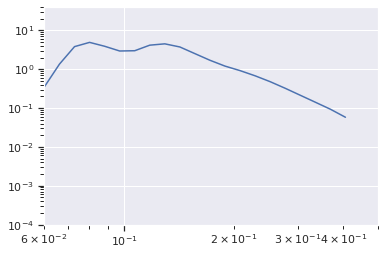

In [68]:
plt.plot(ww1719ef.f.values,coupled_model_ww.EF.sel(NY=nj['sodaB']-100,NX=ni['sodaB']))
plt.loglog()
plt.xlim(0.06,0.5)
plt.ylim(10**-4,4e1)
plt.show()

In [69]:
# ww1719ef.f.values
np.trapz(coupled_model_ww.EF.sel(NY=nj['sodaB']-100,NX=ni['sodaB']),ww1719ef.f.values)**(0.5)*4

2.7579191797820095

In [168]:
coupled_model_ww_mean.HS.sel(NY=nj['sodaB']-30,NX=ni['sodaB']-4)

<xarray.DataArray 'HS' ()>
array(1.4658917, dtype=float32)

In [165]:
coupled_model_ww_mean.HS.sel(NY=nj['sodaB']-10,NX=ni['sodaB']-10)

<xarray.DataArray 'HS' ()>
array(2.3396432, dtype=float32)

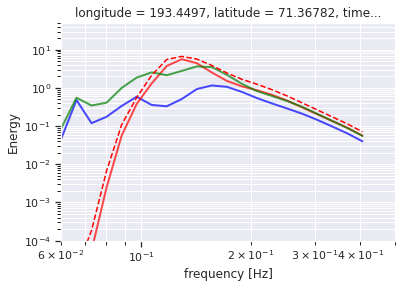

In [206]:
# plt.plot(ww1719ef.f.values,coupled_model_ww_mean.EF.sel(NY=nj['sodaB']-6,NX=ni['sodaB']-4))

# plt.plot(ww1719ef.f.values,coupled_model_ww5.EF.sel(NY=nj['sodaB']-6,NX=ni['sodaB']-4))

# plt.plot(ww1719ef.f.values,coupled_model_ww5.EF.sel(NY=nj['sodaB']-30,NX=ni['sodaB']-4))
plt.plot(ww1719ef.f.values,coupled_model_ww_mean.EF.sel(NY=nj['sodaB']-30,NX=ni['sodaB']-4),c='b',lw=2,alpha=0.7)
# plt.plot(ww1719ef.f.values,coupled_model_ww_mean.EF.sel(NY=nj['sodaB']-200,NX=ni['sodaB']-4))
plt.plot(ww1719ef.f.values,coupled_model_ww_mean.EF.sel(NY=nj['sodaB']-10,NX=ni['sodaB']-10),c='r',lw=2,alpha=0.7)

plt.plot(ww1719ef.f.values,coupled_model_ww_mean.EF.sel(NY=nj['sodaB']-30,NX=ni['sodaB']-15),c='g',lw=2,alpha=0.7)


###
ww1719ef.ef.sel(nj=nj['sodaB']-10,ni=ni['sodaB']-10,time='2018-11-01')[1].plot(c='r',ls='--')
# ww1719ef.ef.sel(nj=nj['sodaB']-10,ni=ni['sodaB']-10,time='2017-11-01')[1].plot(c='k',ls='--')
# ww1719ef.ef.sel(nj=nj['sodaB']-10,ni=ni['sodaB']-10,time='2019-11-01')[1].plot(c='0.5',ls='--')

plt.loglog()
plt.xlim(0.06,0.5)
plt.ylim(10**-4,5e1)
plt.xlabel('frequency [Hz]')
plt.ylabel('Energy')
plt.grid(True,which='both')
plt.show()

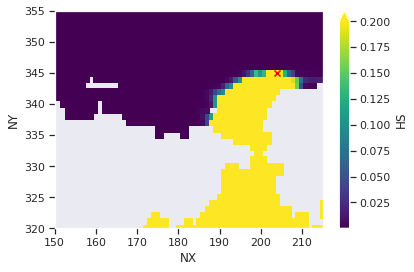

In [121]:
coupled_model_ww_mean.HS.plot(vmax=0.2)
plt.scatter(208-4,nj['sodaB']-6,marker='x',c='r')
plt.xlim(150,215)
plt.ylim(320,355)
# plt.scatter(nj['sodaB']-30, ni['sodaB'],marker='x',c='r',size=10)
plt.show()

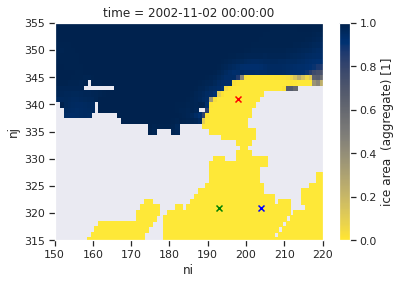

In [188]:
coupled_model_cice.aice_d.plot(cmap='cividis_r')
# plt.scatter(208-4,nj['sodaB']-6,marker='x',c='r')
plt.scatter(208-4,nj['sodaB']-30,marker='x',c='b')
plt.scatter(208-15,nj['sodaB']-30,marker='x',c='g')
plt.scatter(208-10,nj['sodaB']-10,marker='x',c='r')
plt.xlim(150,220)
plt.ylim(315,355)
# plt.scatter(nj['sodaB']-30, ni['sodaB'],marker='x',c='r',size=10)
plt.show()

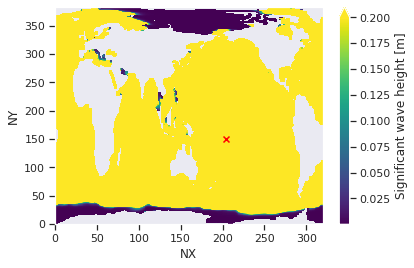

In [152]:
coupled_model_ww5.HS.plot(vmax=0.2)
plt.scatter(208-4,nj['sodaB']-200,marker='x',c='r')
# plt.xlim(150,215)
# plt.ylim(320,355)
# plt.scatter(nj['sodaB']-30, ni['sodaB'],marker='x',c='r',size=10)
plt.show()

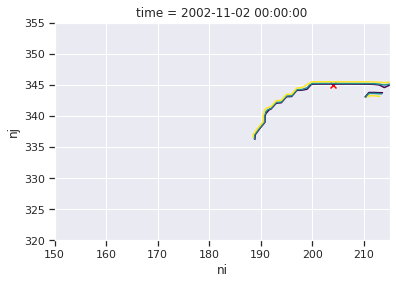

In [135]:
coupled_model_cice.aice_d.squeeze().plot.contour(levels=[0.15,0.25,0.5])
plt.scatter(208-4,nj['sodaB']-6,marker='x',c='r')
plt.xlim(150,215)
plt.ylim(320,355)
# plt.scatter(nj['sodaB']-30, ni['sodaB'],marker='x',c='r',size=10)
plt.show()

In [192]:
ww1719beau

<xarray.Dataset>
Dimensions:    (ni: 320, nj: 84, time: 4380)
Coordinates:
    longitude  (nj, ni) float32 ...
    latitude   (nj, ni) float32 ...
  * time       (time) datetime64[ns] 2017-01-01 ... 2019-12-31T18:00:00
    mask       (nj, ni) bool False False False False ... False False False False
Dimensions without coordinates: ni, nj
Data variables:
    MAPSTA     (nj, ni) int16 ...
    dpt        (time, nj, ni) float32 ...
    uwnd       (time, nj, ni) float32 ...
    vwnd       (time, nj, ni) float32 ...
    ast        (time, nj, ni) float32 ...
    ice        (time, nj, ni) float32 ...
    hs         (time, nj, ni) float32 ...
    lm         (time, nj, ni) float32 ...
    t02        (time, nj, ni) float32 ...
    t0m1       (time, nj, ni) float32 ...
    t01        (time, nj, ni) float32 ...
    fp         (time, nj, ni) float32 ...
    dir        (time, nj, ni) float32 ...
    spr        (time, nj, ni) float32 ...
    dp         (time, nj, ni) float32 ...
Attributes:
    WAVEWATCH_III_version_number:  5.16
    WAVEWATCH_III_switches:        F90 NOGRB NOPA LRB4 NC4 PR3 UQ FLX0 LN1 ST...
    product_name:                  ww3.20000101.nc
    area:                          POP 1 degree grid (gx1v6b)
    latitude_resolution:           n/a
    longitude_resolution:          n/a
    southernmost_latitude:         -79.22052
    northernmost_latitude:         89.70641
    westernmost_longitude:         1.4731102E-02
    easternmost_longitude:         359.9960
    minimum_altitude:              -12000 m
    maximum_altitude:              9000 m
    altitude_resolution:           n/a
    start_date:                    2000-01-01 00:00:00
    stop_date:                     2000-01-01 18:00:00
    nco_openmp_thread_number:      1
    history:                       Fri Jun 26 16:57:55 2020: ncrcat cicefsdww...
    NCO:                           netCDF Operators version 4.7.9 (Homepage =...

In [197]:
ww1719ef.ef.sel(nj=nj['sodaB']-10,ni=ni['sodaB']-10,time='2018-11-01')[0]

<xarray.DataArray 'ef' (f: 25)>
array([5.187822e-10, 1.073148e-08, 2.493404e-07, 1.095380e-06, 7.097297e-06,
       1.620678e-05, 2.465322e-05, 2.660914e-04, 6.146821e-03, 5.159676e-02,
       2.982422e-01, 1.392692e+00, 3.399139e+00, 5.473507e+00, 5.418143e+00,
       3.721037e+00, 2.082450e+00, 1.283081e+00, 9.033954e-01, 6.824722e-01,
       4.821395e-01, 3.221779e-01, 2.079277e-01, 1.352979e-01, 8.400936e-02],
      dtype=float32)
Coordinates:
    longitude  float32 ...
    latitude   float32 ...
  * f          (f) float32 0.04118 0.045298003 ... 0.36873826 0.40561208
    time       datetime64[ns] 2018-11-01
Attributes:
    long_name:      wave_elevation_spectrum
    standard_name:  power_spectral_density_of_surface_elevation
    globwave_name:  power_spectral_density_of_surface_elevation
    units:          m2 s
    valid_min:      -30000
    valid_max:      32000

## Check bit for bit run

In [5]:
## original bit tetst
newrun = xr.open_dataset(
    '/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.cice.h1.2012-01-31.nc')

## full wind
newrun = xr.open_dataset(
    '/glade/scratch/vcooper/cesm23iws1tsks_02wind/run/cesm23iws1tsks_02wind.cice.h1.2012-01-31.nc')

oldrun = xr.open_dataset(
    '/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/refrun/cesm23iws1tsks.cice_nh.h1.2012-01.nc')

In [6]:
oldrun.aice_d[-1]

<xarray.DataArray 'aice_d' (nj: 104, ni: 320)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    TLAT     (nj, ni) float32 ...
    TLON     (nj, ni) float32 ...
    ULAT     (nj, ni) float32 ...
    ULON     (nj, ni) float32 ...
    time     object 2012-02-01 00:00:00
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

In [7]:
icediff = newrun.aice_d.sel(nj=slice(280,384)) - oldrun.aice_d[-1]
sstdiff = newrun.sst_d.sel(nj=slice(280,384)) - oldrun.sst_d[-1]
uwinddiff = newrun.uatm_d.sel(nj=slice(280,384)) - oldrun.uatm_d[-1]
hidiff = newrun.hi_d.sel(nj=slice(280,384)) - oldrun.hi_d[-1]

<xarray.DataArray 'aice_d' ()>
array(-0.20160712, dtype=float32)


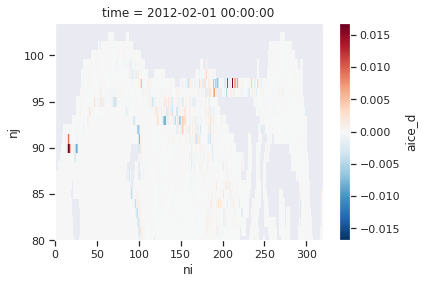

<xarray.DataArray 'sst_d' ()>
array(0.09470277, dtype=float32)


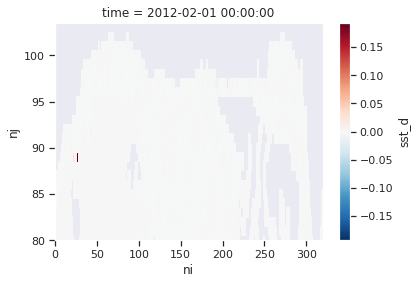

<xarray.DataArray 'uatm_d' ()>
array(0., dtype=float32)


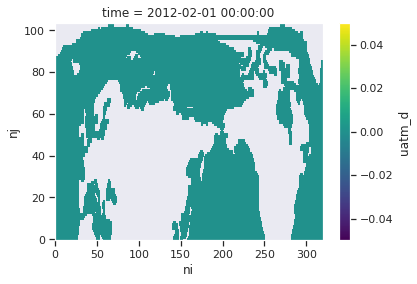

<xarray.DataArray 'hi_d' ()>
array(0.1558558, dtype=float32)


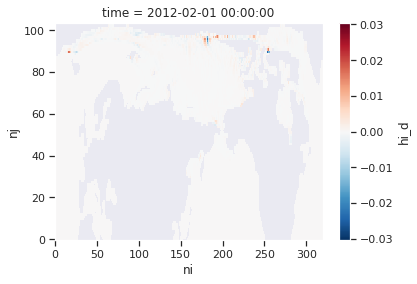

In [18]:
print(icediff.sum())
icediff.plot()
plt.ylim(80,)
plt.show()

print(sstdiff.sum())
sstdiff.plot()
plt.ylim(80,)
plt.show()

print(uwinddiff.sum())
uwinddiff.plot()
plt.show()

print(hidiff.sum())
hidiff.plot()
plt.show()
plt.show()

### attempt to use open mf dataset for loading Hs only

In [5]:
import dask
from glob import glob

In [14]:
# newrun = xr.open_dataset(
#     '/glade/scratch/vcooper/cesm23iws1tsks_02wind/run/cesm23iws1tsks_02wind.cice.h1.2012-01-31.nc')


In [37]:
newrun_ww = xr.open_dataset(
    '/glade/scratch/vcooper/cesm23iws1tsks_02wind/run/cesm23iws1tsks_02wind.ww3.hi.2012-10-12-00000.nc')

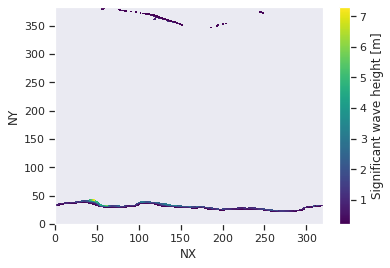

In [38]:
newrun_ww.HS.where((newrun_ww.ICE > 0.15) & (newrun_ww.HS > 0.2)).plot()

In [98]:
def preprocess(ds):
    ds = ds[['HS','ICE']]
    ds = ds.expand_dims(time = [datetime.datetime.now()]) ## dummy time
    return ds

In [115]:
rundir = '/glade/scratch/vcooper/cesm23iws1tsks_02wind/run/'
flist = 'cesm23iws1tsks_02wind.ww3.hi.2012-*.nc'
dfiles = sorted(glob(rundir + flist))
dfiles;
print(len(dfiles), len(ww2012.time))

8760 8760


In [11]:
mfds = xr.open_mfdataset(dfiles,
#                          combine='nested',
                         concat_dim='time',
                         preprocess=preprocess,
                         parallel=True)

In [116]:
%%time
mfds_temp = xr.open_mfdataset(dfiles,
                              coords='minimal',
                              concat_dim='time',
                              compat='override',
                              preprocess=preprocess,
                              parallel=False)

CPU times: user 54.4 s, sys: 2.37 s, total: 56.8 s
Wall time: 9min 30s


In [117]:
%%time
mfds_temp.load()

CPU times: user 50.1 s, sys: 1min 43s, total: 2min 33s
Wall time: 18min 39s


<xarray.Dataset>
Dimensions:  (NX: 320, NY: 384, time: 8760)
Coordinates:
  * time     (time) datetime64[ns] 2021-08-17T13:29:33.483725 ... 2021-08-17T...
Dimensions without coordinates: NX, NY
Data variables:
    HS       (time, NY, NX) float32 nan nan nan nan nan ... nan nan nan nan nan
    ICE      (time, NY, NX) float32 nan nan nan nan nan ... nan nan nan nan nan

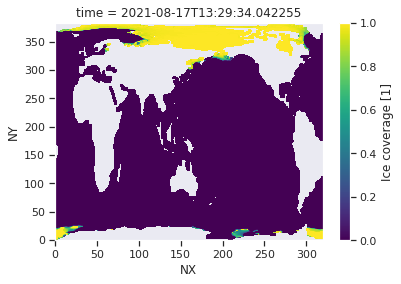

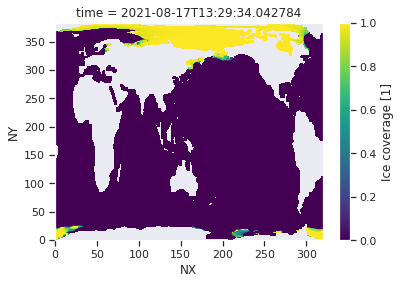

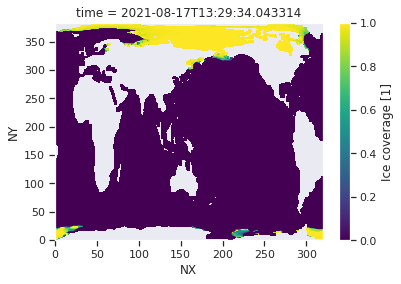

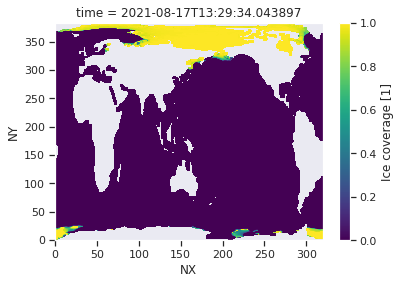

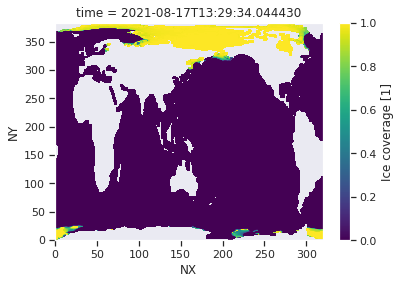

In [118]:
mfds_temp.ICE[1001].plot()
plt.show()
mfds_temp.ICE[1002].plot()
plt.show()
mfds_temp.ICE[1003].plot()
plt.show()
mfds_temp.ICE[1004].plot()
plt.show()
mfds_temp.ICE[1005].plot()
plt.show()

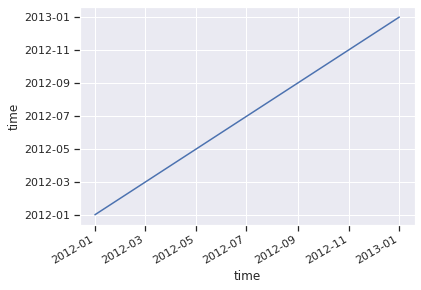

In [114]:
ww2012.time.plot()

In [121]:
mfds_temp['time'] = ww2012.time
# mfds_temp#.load()

In [42]:
wave_extent2 = wave_extent2/(1000**2) / 1e6 ## convert to 10^6 km^2

In [29]:
%%time
wave_extent2 = xr.where(
    (mfds.HS.sel(NY=latslice) > 0.1) & (mfds.ICE.sel(NY=latslice) > 0.15),
    tarea.values[300:,:],0).sum(dim=('NY','NX'))
wave_extent2 = wave_extent2/(1000**2) / 1e6 ## convert to 10^6 km^2

CPU times: user 1.14 s, sys: 3.06 s, total: 4.21 s
Wall time: 14.5 s


In [123]:
%%time
wave_extent3 = xr.where(
    (mfds_temp.HS.sel(NY=latslice) > 0.1) & (mfds_temp.ICE.sel(NY=latslice) > 0.15),
    tarea.values[300:,:],0).sum(dim=('NY','NX'))
wave_extent3 = wave_extent3/(1000**2) / 1e6 ## convert to 10^6 km^2

CPU times: user 990 ms, sys: 1.36 s, total: 2.35 s
Wall time: 11.2 s


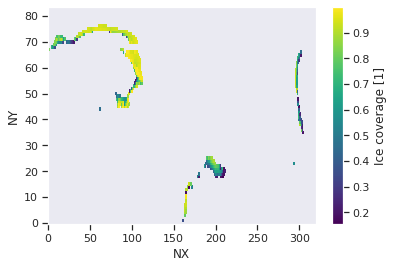

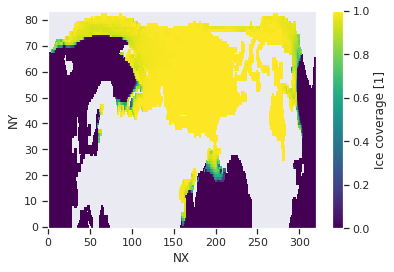

In [92]:
ind = 0
tempds.ICE.sel(NY=latslice).where(
    (tempds.HS.sel(NY=latslice) > 0.1) & (tempds.ICE.sel(NY=latslice) > 0.15)).plot()
plt.show()

tempds.ICE.sel(NY=latslice).plot()
plt.show()

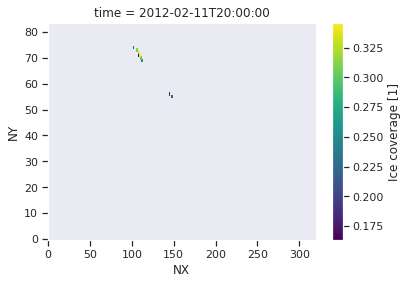

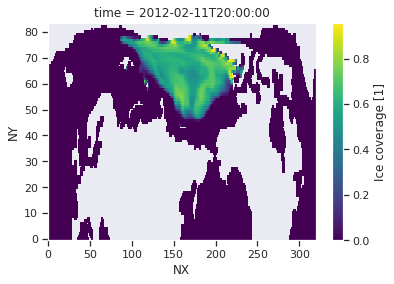

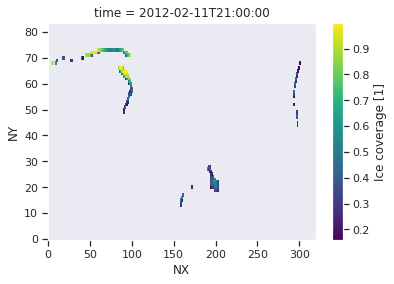

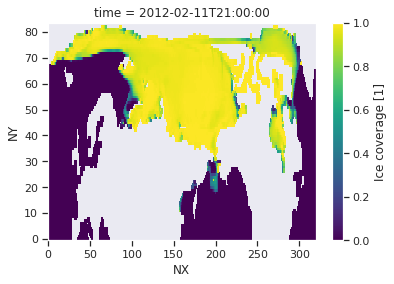

In [82]:
ind = 1004
mfds.ICE[ind].sel(NY=latslice).where(
    (mfds.HS[ind].sel(NY=latslice) > 0.1) & (mfds.ICE[ind].sel(NY=latslice) > 0.15)).plot()
plt.show()

mfds.ICE[ind].sel(NY=latslice).plot()
plt.show()

ind = 1005
mfds.ICE[ind].sel(NY=latslice).where(
    (mfds.HS[ind].sel(NY=latslice) > 0.1) & (mfds.ICE[ind].sel(NY=latslice) > 0.15)).plot()
plt.show()

mfds.ICE[ind].sel(NY=latslice).plot()
plt.show()

In [32]:
wave_extent_annual = xr.open_dataarray('./wave_extent_annual.nc')
wave_extent = wave_extent_annual.values

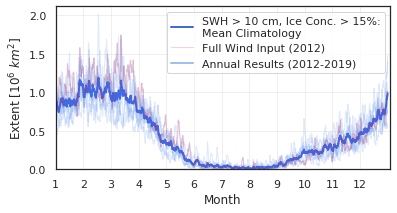

In [125]:
# from cycler import cycler

# color_cyc = [str(i) for i in (np.arange(8)+1)/10]
# color_cyc
# custom_cycler = (cycler(color=color_cyc))

## monthly version of x axis
xx = np.linspace(1,12.999,len(wave_extent[:,0]))

with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(6,3),dpi=72)
#     ax.set_prop_cycle(custom_cycler)


    [plt.plot(xx,wave_extent[:,j],alpha=0.2,lw=1,c='cornflowerblue') for j in range(8)]
    
    plt.plot(xx,wave_extent.mean(axis=1),c='royalblue',lw=2,
             label='SWH > 10 cm, Ice Conc. > 15%:\nMean Climatology')
    plt.plot(xx,wave_extent3.values,c='crimson',lw=1,alpha=0.2,
             label='Full Wind Input (2012)')
    
    ## dummy for legend
    plt.plot(xx+10000,wave_extent[:,0],alpha=0.6,lw=2,c='cornflowerblue',label='Annual Results (2012-2019)')
    
    plt.ylim(0,)
    plt.xlim(1,13.1)
    plt.xticks(np.arange(12)+1)
    plt.grid(True,alpha=0.3)
#     plt.title('Wave-Affected Ice Extent ($H_s$ > 10 cm, Ice > 15%)')
    plt.ylabel('Extent [$10^6$ $km^2$]')
    plt.xlabel('Month')
    plt.legend()
    plt.show()

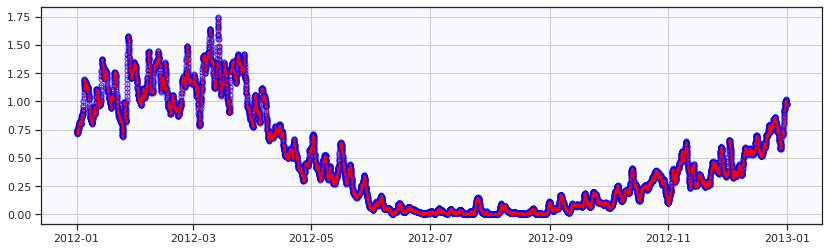

In [146]:
with sns.axes_style('ticks'):
    plt.subplots(figsize=(14,4))
    ax = plt.subplot()
    plt.plot(mfds_temp.time,wave_extent3,marker='o',lw=0,alpha=0.8,mfc='none',c='b',markersize=5)
    plt.plot(mfds_temp.time,wave_extent[:,0],marker='.',lw=0,alpha=0.8,markersize=2,c='r')
    ax.set_facecolor('ghostwhite')
    plt.grid(True)
    # plt.plot(wave_extent[:,7],marker='.',lw=0,alpha=0.2)
    plt.show()

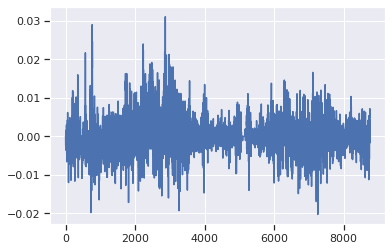

In [149]:
plt.plot(wave_extent3 - wave_extent[:,0])

In [41]:
%%time
mfds.to_netcdf('/glade/scratch/vcooper/cesm23iws1tsks_02wind/run/ww2012concat.nc')

CPU times: user 5.64 s, sys: 25 s, total: 30.7 s
Wall time: 1min 39s


In [122]:
%%time
mfds_temp.to_netcdf('/glade/scratch/vcooper/cesm23iws1tsks_02wind/run/ww2012concat2.nc')

CPU times: user 5.48 s, sys: 23.8 s, total: 29.2 s
Wall time: 1min 33s
